In [ ]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs.git

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random
import requests
from PIL import Image

#fit generator(data argumentation) to better improve our image classification, meaning we can zoom in on an image or rotate the image or a combo of both
#variety it allows our model to look at the same image from different perspective 

In [ ]:
 np.random.seed(0)

In [ ]:
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)

with open('german-traffic-signs/valid.p', 'rb') as f:
  valid_data = pickle.load(f)

with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)

In [ ]:
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = valid_data['features'], valid_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [ ]:
assert(X_train.shape[0] == y_train.shape[0])
assert(X_test.shape[0] == y_test.shape[0])
assert(X_val.shape[0] == y_val.shape[0])
assert(X_train.shape[1:] == (32, 32, 3))
assert(X_val.shape[1:] == (32, 32, 3))
assert(X_test.shape[1:] == (32, 32, 3))

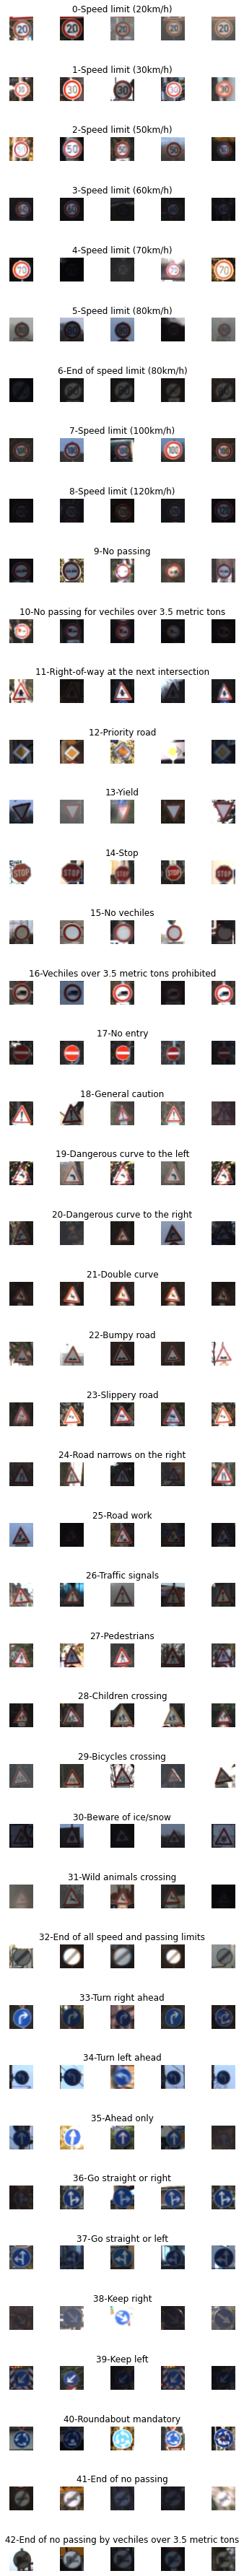

In [ ]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
num_of_samples = []
cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5, 50))
fig.tight_layout()
for i in range(cols):
  for j, row in data.iterrows():
    x_selected = X_train[y_train == j]
    axs[j][i].imshow(x_selected[random.randint(0, len(x_selected-1)), :, :], cmap=plt.get_cmap("gray"))
    axs[j][i].axis("off")
    if i == 2:
      axs[j][i].set_title(str(j) + '-' + row["SignName"])
      num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'Number of images')

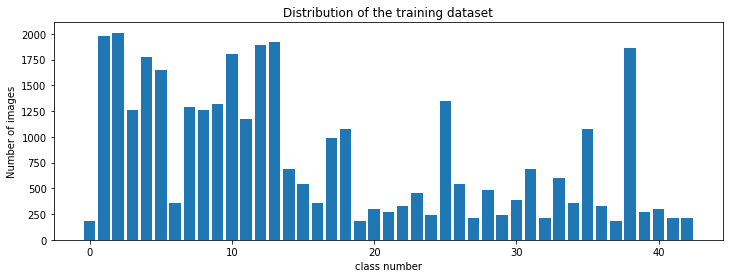

In [ ]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes),  num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("class number")
plt.ylabel("Number of images")

(32, 32, 3)
36


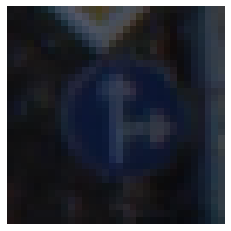

In [ ]:
import cv2

plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

In [ ]:
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

img = grayscale(X_train[99])

(32, 32)


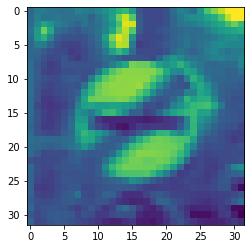

In [ ]:
plt.imshow(img)
print(img.shape)

In [ ]:
#histogram equalization, standrize lighting of our images
def equalize(img):

  img = cv2.equalizeHist(img)
  return img

(32, 32)


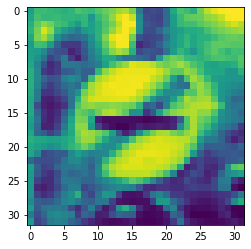

In [ ]:
img = equalize(img)
plt.imshow(img)
print(img.shape)

In [ ]:
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  img = img/255
  return img
X_train = np.array(list(map(preprocessing, X_train)))
X_test = np.array(list(map(preprocessing, X_test)))
X_val = np.array(list(map(preprocessing, X_val)))

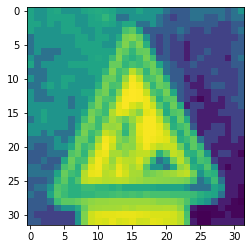

In [ ]:
plt.imshow(X_train[random.randint(0,len(X_train)-1)])

In [ ]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
data_gen = ImageDataGenerator(width_shift_range=0.1,
                   height_shift_range=0.1,
                   zoom_range=0.2,
                   shear_range=0.1, 
                   rotation_range=10)
data_gen.fit(X_train)

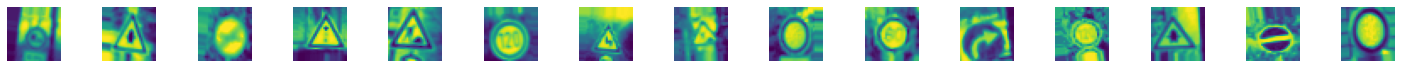

In [ ]:
batches = data_gen.flow(X_train, y_train, batch_size=20)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize=(20,5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32,32))
  axs[i].axis('off')

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)


In [ ]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [ ]:
# def leNet_model():
#   #increase filter in conv layer or decrease learning_rate or extra covolutional
#   model = Sequential()
#   model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
#   model.add(MaxPooling2D(pool_size=(2,2))) #pooling will scale down all the feature apps from the convolutional layer into a small generalized representation
#   model.add(Conv2D(30, (3,3), activation='relu'))
#   model.add(MaxPooling2D(pool_size=(2,2)))
#   model.add(Flatten())
#   model.add(Dense(500, activation='relu'))
#   model.add(Dropout(0.5))
#   model.add(Dense(num_classes, activation='softmax'))
#   model.compile(Adam(learning_rate=0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
#   return model

In [ ]:
def modified_model():
  #increase filter in conv layer or decrease learning_rate or extra covolutional
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(60, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2))) #pooling will scale down all the feature apps from the convolutional layer into a small generalized representation
  
  model.add(Conv2D(30, (3,3), activation='relu'))
  model.add(Conv2D(30, (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  # model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5)) #drop out layer is an effective way of preventing over fitting
  model.add(Dense(num_classes, activation='softmax'))
  model.compile(Adam(learning_rate=0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
  return model

In [ ]:
model = modified_model()
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 480)              

In [ ]:
#There might be some updates on fit_generator. According to the documentation (https://keras.rstudio.com/reference/fit_generator.html), 
#the steps_per_epoch = int(len(X_train)/batch_size), i.e. 695 instead of 2000.
history = model.fit_generator(data_gen.flow(X_train, y_train, batch_size=50), steps_per_epoch=695, epochs=10, validation_data=(X_val, y_val), shuffle=1, verbose=1)

Epoch 1/10
  7/695 [..............................] - ETA: 12s - loss: 0.3406 - accuracy: 0.8971

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


695/695 [==============================] - 13s 19ms/step - loss: 0.3160 - accuracy: 0.9005 - val_loss: 0.0924 - val_accuracy: 0.9717
Epoch 2/10
695/695 [==============================] - 13s 18ms/step - loss: 0.2407 - accuracy: 0.9248 - val_loss: 0.0713 - val_accuracy: 0.9760
Epoch 3/10
695/695 [==============================] - 13s 18ms/step - loss: 0.1915 - accuracy: 0.9414 - val_loss: 0.0577 - val_accuracy: 0.9807
Epoch 4/10
695/695 [==============================] - 13s 18ms/step - loss: 0.1712 - accuracy: 0.9460 - val_loss: 0.0414 - val_accuracy: 0.9871
Epoch 5/10
695/695 [==============================] - 12s 18ms/step - loss: 0.1475 - accuracy: 0.9538 - val_loss: 0.0494 - val_accuracy: 0.9848
Epoch 6/10
695/695 [==============================] - 13s 18ms/step - loss: 0.1340 - accuracy: 0.9579 - val_loss: 0.0422 - val_accuracy: 0.9887
Epoch 7/10
695/695 [==============================] - 13s 18ms/step - loss: 0.1248 - accuracy: 0.9612 - val_loss: 0.0651 - val_accuracy: 0.9823
Epo

Text(0.5, 0, 'epoch')

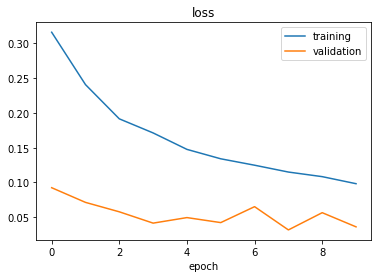

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('epoch')

#validation loss should always be lower than training losa

Text(0.5, 0, 'epoch')

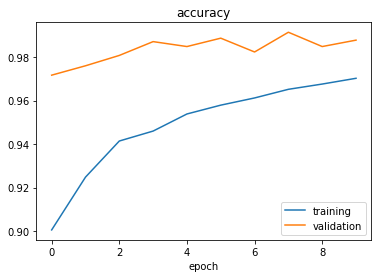

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('accuracy')
plt.xlabel('epoch')
#validation accuracy should always be higher than training acciracu

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print("test score: ", score[0])
print("test accuracy", score[1])

test score:  0.15481680631637573
test accuracy 0.963341236114502


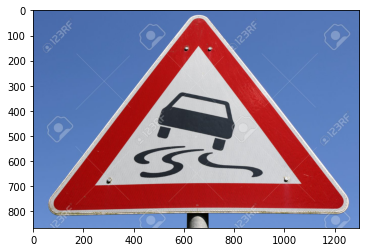

In [ ]:
url = 'https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))


(32, 32)


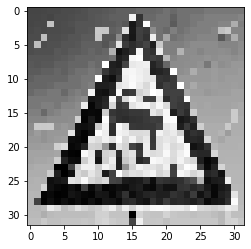

In [ ]:
img = np.asarray(img)
img = cv2.resize(img, (32,32))
img = preprocessing(img)
plt.imshow(img, cmap=plt.get_cmap('gray'))
print(img.shape)

In [ ]:
img = img.reshape(1, 32, 32, 1)

In [ ]:
print("predicted sign: "+ str(np.argmax(model.predict(img), axis=-1)))

predicted sign: [23]
